In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline

df = pd.read_csv("tracks.csv")

In [16]:
df["popularity"].describe()

count    1500.000000
mean       28.554000
std        24.038587
min         0.000000
25%         1.000000
50%        25.000000
75%        47.000000
max        93.000000
Name: popularity, dtype: float64

In [17]:
m = df["popularity"].median()
print(m)

25.0


In [18]:
df["popularity_binary"] = df["popularity"].map(lambda x: 1 if x > m else 0)
df.drop(columns=["popularity"], inplace=True)

df["explicit"] = df["explicit"].map({True: 1, False: 0})
df = pd.get_dummies(df, drop_first=True, dtype=int)

In [19]:
df

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_binary,track_genre_dance,track_genre_opera
0,202093,1,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.1660,100.966,4,1,0,0
1,215973,0,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.1460,100.005,4,1,0,0
2,188160,0,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.3490,124.979,4,1,0,0
3,233965,0,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.1970,101.033,4,1,0,0
4,187173,0,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.2190,123.983,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,352371,0,0.273,0.122,0,-22.173,0,0.0575,0.96000,0.003330,0.0635,0.0731,117.718,4,0,0,1
1496,204310,0,0.457,0.498,6,-8.387,1,0.0368,0.76600,0.000002,0.2890,0.2020,116.255,4,0,0,1
1497,225506,0,0.241,0.207,1,-16.353,1,0.0374,0.98200,0.002260,0.1140,0.0735,86.885,1,0,0,1
1498,148600,0,0.280,0.208,5,-20.158,1,0.0521,0.94100,0.000200,0.4100,0.2410,90.477,4,0,0,1


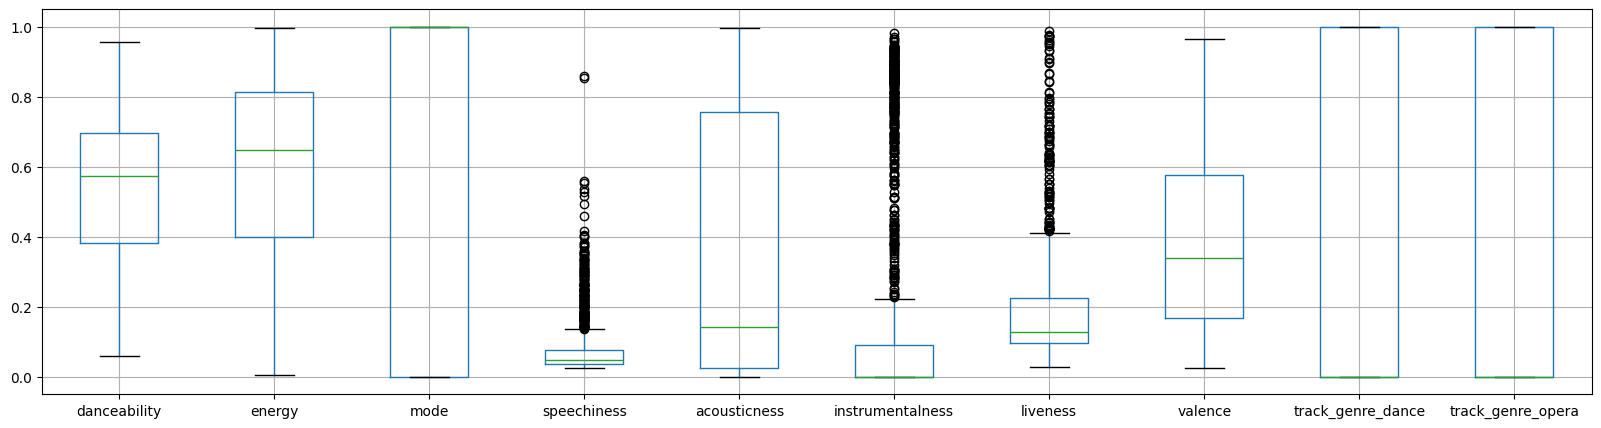

In [20]:
# look at all cols with vals between -1 and 1
df.drop(columns=["duration_ms", "tempo", "loudness", "explicit", "key", "time_signature", "popularity_binary"]).boxplot(
    figsize=(20, 5))
plt.show()

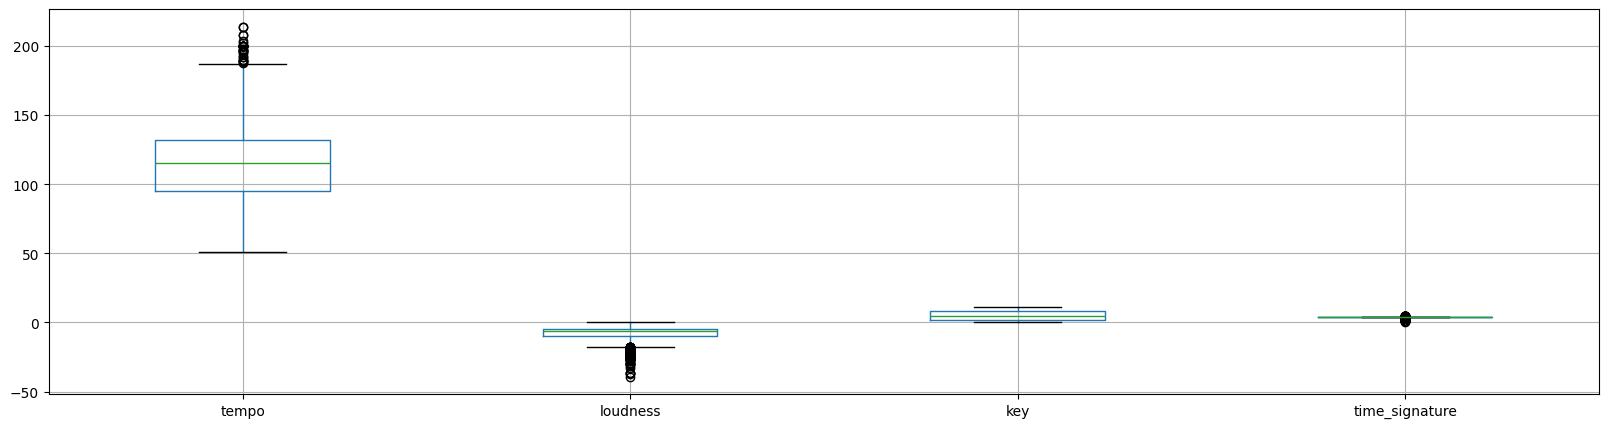

In [21]:
# look at all cols with vals between -1 and 1
df[["tempo", "loudness", "key", "time_signature"]].boxplot(figsize=(20, 5))
plt.show()

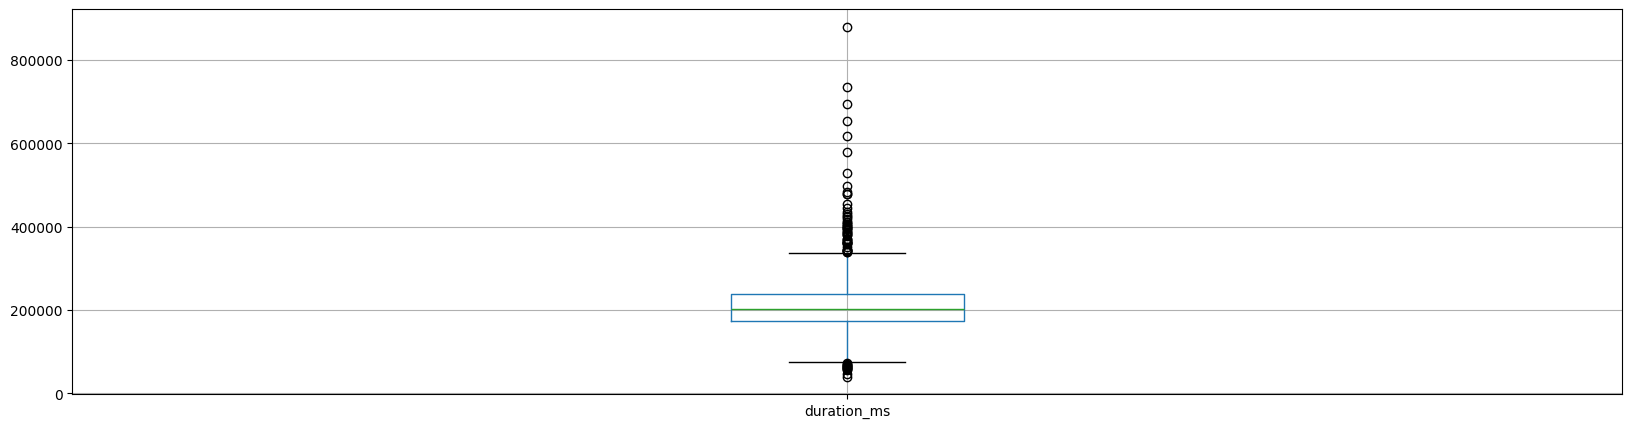

In [22]:
df[["duration_ms"]].boxplot(figsize=(20, 5))
plt.show()

outliers
- duration
- loudness
- speechiness
- instrumentalness
- liveness
- tempo
- time_signature

In [23]:
df.isna().sum()

duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
popularity_binary    0
track_genre_dance    0
track_genre_opera    0
dtype: int64

In [24]:
df["explicit"].value_counts()

explicit
0    1343
1     157
Name: count, dtype: int64

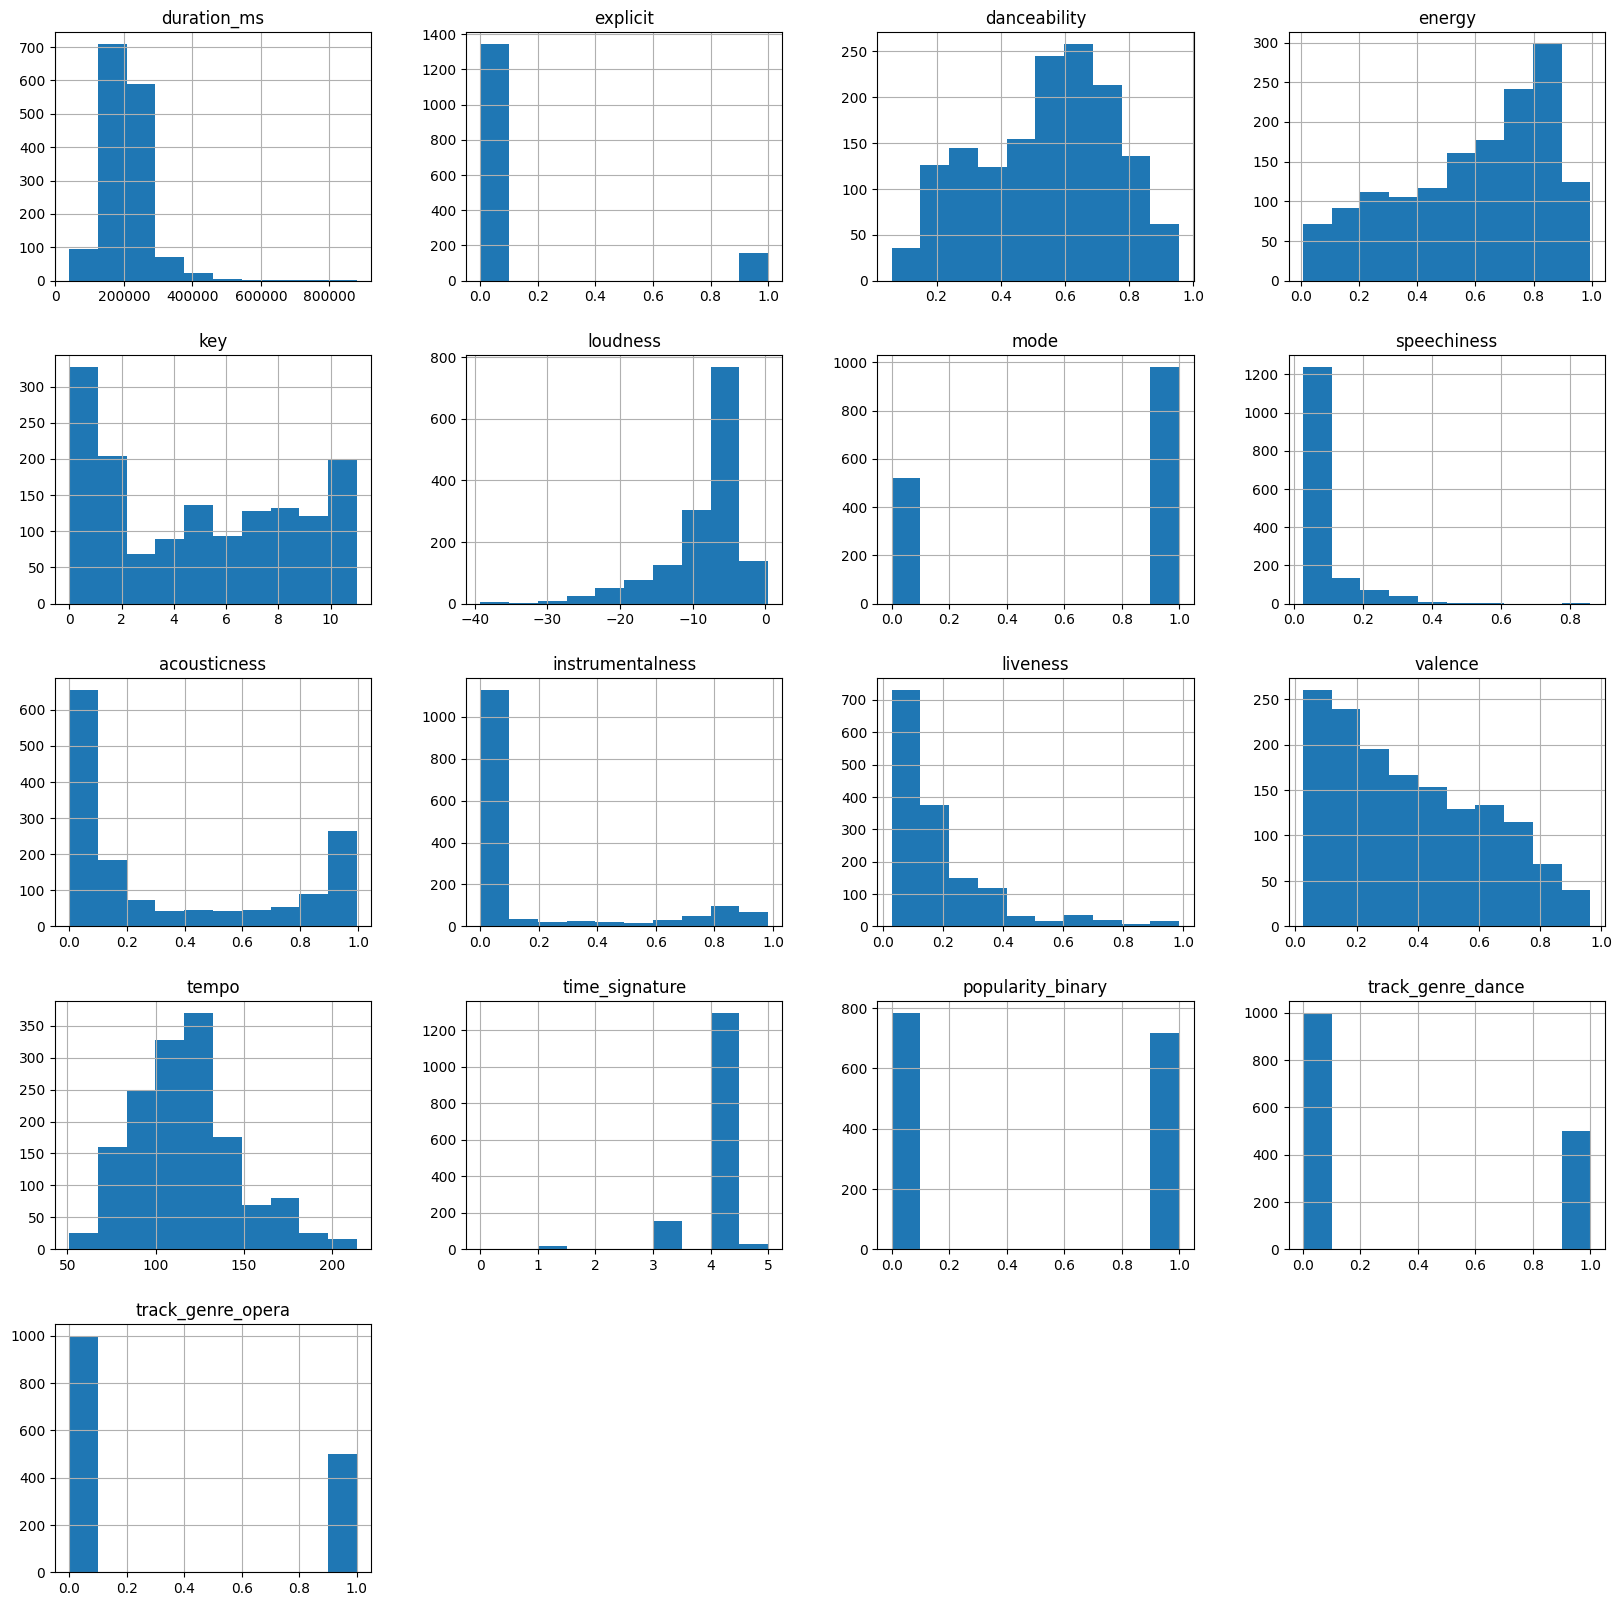

In [25]:
df.hist(figsize=(20, 20))
plt.show()

In [26]:
from sklearn.preprocessing import PolynomialFeatures

y = df['popularity_binary']
X = df.drop('popularity_binary', axis=1)

df['tempo_acousticness'] = df['tempo'] * df['acousticness']
df['danceability_energy'] = df['danceability'] * df['energy']
df['loudness_valence'] = df['loudness'] * df['valence']
df['duration_tempo'] = df['duration_ms'] * df['tempo']

top_feats = ['tempo', 'acousticness', 'danceability', 'energy']
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_arr = poly.fit_transform(df[top_feats])
poly_cols = poly.get_feature_names_out(top_feats)

poly_df = pd.DataFrame(poly_arr, columns=poly_cols, index=df.index)
poly_new = poly_df.drop(columns=top_feats)
df = pd.concat([df, poly_new], axis=1)

In [27]:
# outliers
# - duration
# - loudness
# - speechiness
# - instrumentalness
# - liveness
# - tempo
# - time_signature

columns_outliers = ["duration_ms", "loudness", "speechiness", "instrumentalness", "liveness", "tempo", "time_signature"]

columns_no_outliers_skewed = ["duration_ms",
                              "danceability",
                              "energy",
                              "key",
                              "loudness",
                              "speechiness",
                              "acousticness",
                              "instrumentalness",
                              "liveness",
                              "valence",
                              "tempo",
                              "time_signature"]
columns_no_outliers_no_skew = [col for col in X.columns if col not in columns_outliers and col not in columns_no_outliers_skewed]

outliers_pipeline = Pipeline(
    steps=[
        ("log_transform", PowerTransformer(method="yeo-johnson")),
        ("scaler", RobustScaler())
    ]
)

no_outliers_skewed_pipeline = Pipeline(
    steps=[
        ("log_transform", PowerTransformer(method="yeo-johnson")),
        ("scaler", MinMaxScaler())
    ]
)

no_outliers_no_skew_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("outliers_not_skewed", outliers_pipeline, columns_outliers),
        ("no_outliers_skewed", no_outliers_skewed_pipeline, columns_no_outliers_skewed),
        ("no_outliers_no_skew", no_outliers_no_skew_pipeline, columns_no_outliers_no_skew)
    ],
    remainder="passthrough"
)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [29]:
df["popularity_binary"].value_counts()

popularity_binary
0    784
1    716
Name: count, dtype: int64

In [30]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Random Forest

In [31]:
from sklearn.feature_selection import RFE

rfe_estimator = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)
rfe = RFE(estimator=rfe_estimator, step=0.1)

In [32]:
from sklearn.decomposition import PCA

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       # ('feature_sel', rfe),
                       # ('pca', PCA()),
                       ('rf', RandomForestClassifier())])

In [33]:
from sklearn.model_selection import RandomizedSearchCV

# prepare a parameter grid
param_grid = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [5, 7, 8, 10, 15],
    # 'feature_sel__n_features_to_select': [14, 15, 16],
    # 'feature_sel__step': [0.1, 0.2, 0.3],
    # 'pca__n_components': [5, 10, 15, 20],  # number of principal axes
    # 'pca__whiten': [False, True],  # whether to whiten components
}

search_rf = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    n_iter=30,
    # scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42
)

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

# .765

C:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best CV score = 0.768:
Best parameters:  {'rf__max_depth': 10, 'rf__n_estimators': 200}


## SVM

In [34]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

In [35]:
# # prepare a parameter grid
# param_grid = {
#     'svm__C': [0.1, 1, 10, 100],
#     'svm__gamma': [1, 0.1, 0.01, 0.001],
#     'svm__kernel': ['rbf', 'linear', 'poly']}
#
# search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
# search.fit(X_train, y_train)
#
# print("Best CV score = %0.3f:" % search.best_score_)
# print("Best parameters: ", search.best_params_)
#
# # store the best params and best model for later use
# SVM_best_params = search.best_params_
# SVM_best_model = search.best_estimator_

# Best CV score = 0.723:
# Best parameters:  {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

## KNN

In [36]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       # ('feature_sel', rfe),
                       ('pca', PCA()),
                       ('knn', KNeighborsClassifier())])

In [37]:


# prepare a parameter grid
param_grid = {
    'knn__n_neighbors': [5, 10, 15],
    'knn__weights': ["uniform", "distance"],
    # 'feature_sel__n_features_to_select': [14, 15, 16],
    # 'feature_sel__step': [0.1, 0.2, 0.3],
    'pca__n_components': [5, 10, 15, 20],  # number of principal axes
    'pca__whiten': [False, True],  # whether to whiten components
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)

search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.722:
Best parameters:  {'knn__n_neighbors': 10, 'knn__weights': 'distance', 'pca__n_components': 15, 'pca__whiten': True}


C:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## XGB

In [38]:
from sklearn.model_selection import StratifiedKFold

In [39]:
from xgboost import XGBClassifier

pipe_xgb = Pipeline([
    ('preprocess', preprocess_pipeline),
    # ('feature_sel', rfe),
    # ('pca', PCA()),

    ('xgb', XGBClassifier(
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )),
])

In [40]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'xgb__n_estimators': [300, 500, 600],
    'xgb__max_depth': [8, 9, 10, 11],
    'xgb__learning_rate': [0.001, 0.005, 0.01],
    'xgb__subsample': [0.5, 0.6, 0.8, 1.0],
    # 'feature_sel__n_features_to_select': [14, 15, 16],
    # 'feature_sel__step': [0.1, 0.2, 0.3],
    # 'pca__n_components': [5, 10, 15, 20],  # number of principal axes
    # 'pca__whiten': [False, True],  # whether to whiten components
}

search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist,
    n_iter=30,
    # scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42
)
search_xgb.fit(X_train, y_train)

print("Best XGB CV:", search_xgb.best_score_)
print("Best XGB Params:", search_xgb.best_params_)

XGB_best_model = search_xgb.best_estimator_

# .765 with no feature selection stuff

C:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [05:38:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB CV: 0.7650000000000001
Best XGB Params: {'xgb__subsample': 0.8, 'xgb__n_estimators': 600, 'xgb__max_depth': 11, 'xgb__learning_rate': 0.005}


## MLP

In [41]:
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier

pipe_mlp = Pipeline([
    ('preprocess', preprocess_pipeline),
    # ('pca', PCA()),
    ('clf', MLPClassifier(
        random_state=42,
        max_iter=200,  # you can bump this if it still hasn’t converged
        early_stopping=True,  # uses 10% of the train‐split as a validation set
    )),
])

In [42]:
param_dist = {
    'clf__hidden_layer_sizes': [(100, 50), (100, 100), (150, 100), (150, 150)],
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'clf__learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__learning_rate': ['constant', 'adaptive'],
    # 'pca__n_components': [5, 10, 15, 20],  # number of principal axes
    # 'pca__whiten': [False, True],  # whether to whiten componentss
}

search_mlp = RandomizedSearchCV(
    pipe_mlp,
    param_distributions=param_dist,
    # n_iter=20,
    # scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
)
search_mlp.fit(X_train, y_train)

MLP_best_model = search_mlp.best_estimator_

print("Best MLP CV:", search_mlp.best_score_)
print("Best MLP params:", search_mlp.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best MLP CV: 0.7141666666666666
Best MLP params: {'clf__learning_rate_init': 0.01, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (150, 100), 'clf__alpha': 0.1, 'clf__activation': 'relu'}


## Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ('preprocess', preprocess_pipeline),
    # ('pca', PCA()),
    ('clf', LogisticRegression(
        max_iter=1000, solver='saga', random_state=42
    )),
])

In [44]:
param_dist = {
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
    # 'pca__n_components': [5, 10, 15, 20],  # number of principal axes
    # 'pca__whiten': [False, True],  # whether to whiten components
}

search_mlp = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_dist,
    # n_iter=20,
    # scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
)
search_mlp.fit(X_train, y_train)

print("Best MLP CV:", search_mlp.best_score_)
print("Best MLP params:", search_mlp.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best MLP CV: 0.71
Best MLP params: {'clf__penalty': 'l1', 'clf__C': np.float64(0.1)}


## CatBoost

In [57]:
from catboost import CatBoostClassifier, Pool

pipe_cb = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('pca', PCA()),
    ('clf', CatBoostClassifier(
        random_seed=42,
        verbose=0,
        early_stopping_rounds=50,
        depth=4,
        l2_leaf_reg=10,
    )),
])

In [58]:
param_dist = {
    'clf__iterations': [200, 500, 800],
    # 'clf__depth': [4, 6, 8],
    'clf__learning_rate': [0.01, 0.03, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__rsm': [0.6, 0.8, 1.0],
    # 'clf__l2_leaf_reg': [1, 3, 5, 7, 9],
    'clf__bagging_temperature': [0.0, 0.2, 0.5, 1.0],
    'clf__random_strength': [0, 1, 2, 3],
    'pca__n_components': [5, 10, 15, 20],  # number of principal axes
    'pca__whiten': [False, True],  # whether to whiten components
}

search_cb = RandomizedSearchCV(
    pipe_cb,
    param_distributions=param_dist,
    # n_iter=20,
    # scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
)
search_cb.fit(X_train, y_train)

CB_best_model = search_cb.best_estimator_

print("Best CB CV:", search_cb.best_score_)
print("Best CB params:", search_cb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best CB CV: 0.7158333333333333
Best CB params: {'pca__whiten': False, 'pca__n_components': 20, 'clf__subsample': 1.0, 'clf__rsm': 0.8, 'clf__random_strength': 3, 'clf__learning_rate': 0.03, 'clf__iterations': 200, 'clf__bagging_temperature': 0.5}


# Evaluation

In [47]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [48]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc


# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]

    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)

    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)

    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

    # compute fpr and tpr values for various thresholds
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    # compute the area under the curve
    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [49]:
# SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)
XGB_accuracy, XGB_precision, XGB_recall, XGB_f1_score, XGB_tpr, XGB_auc = evaluate_model(X_test, y_test, XGB_best_model)
CB_accuracy, CB_precision, CB_recall, CB_f1_score, CB_tpr, CB_auc = evaluate_model(X_test, y_test, CB_best_model)

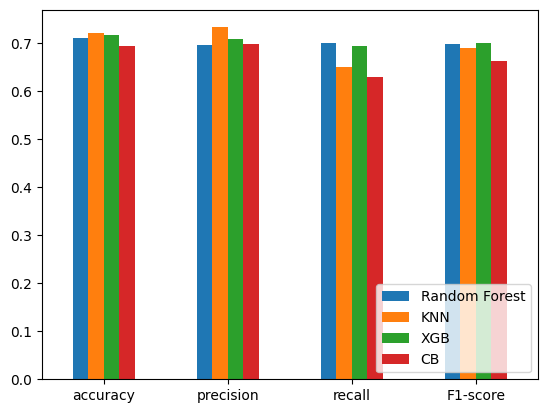

In [50]:
XGB_metrics = np.array([XGB_accuracy, XGB_precision, XGB_recall, XGB_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
CB_metrics = np.array([CB_accuracy, CB_precision, CB_recall, CB_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics, 'KNN': KNN_metrics, "XGB": XGB_metrics, "CB": CB_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

In [51]:
XGB_precision

np.float64(0.7071428571428572)

In [52]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

voting = VotingClassifier(
    estimators=[('knn', KNN_best_model), ('rf', RF_best_model), ('xgb', XGB_best_model), ('cb', CB_best_model)],
    voting='soft',  # use predict_proba averages
)

voting.fit(X_train, y_train)
y_pred_v = voting.predict(X_test)

print("Voting Ensemble Accuracy:", accuracy_score(y_test, y_pred_v))


C:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [05:39:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Voting Ensemble Accuracy: 0.7066666666666667


In [53]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train, discrete_features='auto')
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
print(mi_series.head(10))


acousticness         0.120019
loudness             0.111844
tempo                0.106756
energy               0.101276
danceability         0.078906
duration_ms          0.075939
valence              0.068947
instrumentalness     0.058772
liveness             0.044032
track_genre_dance    0.043627
dtype: float64


In [54]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

dummy = DummyClassifier(strategy='most_frequent')
scores = cross_val_score(dummy, X, y, cv=cv, scoring='accuracy')
print("Most‐frequent baseline:", scores.mean())


Most‐frequent baseline: 0.5226666666666667


In [55]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=1, random_state=42)
scores = cross_val_score(dt, X[['tempo']], y, cv=cv, scoring='accuracy')
print("Tempo‐only stump:", scores.mean())


Tempo‐only stump: 0.5093333333333334


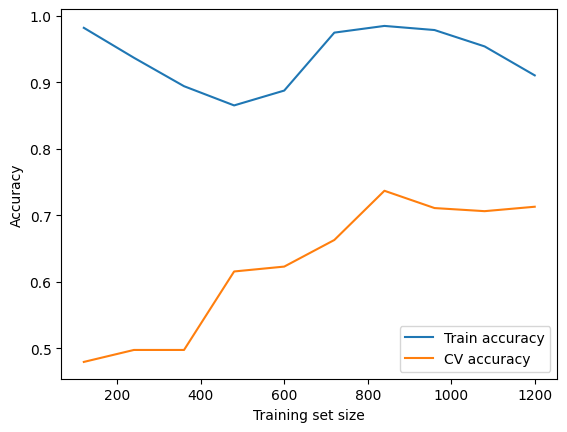

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Use your final pipeline + best parameters
model = search_cb  # or CB_best_model, XGB_best_model, etc.

train_sizes, train_scores, cv_scores = learning_curve(
    model,
    X, y,
    cv=cv,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
cv_mean = cv_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Train accuracy')
plt.plot(train_sizes, cv_mean, label='CV accuracy')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
